In [2]:
from StackedLinePlot_v2 import StackedLinePlot

Importing CSV with the file path: leesferry_webservice.csv
[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 336]
['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01']


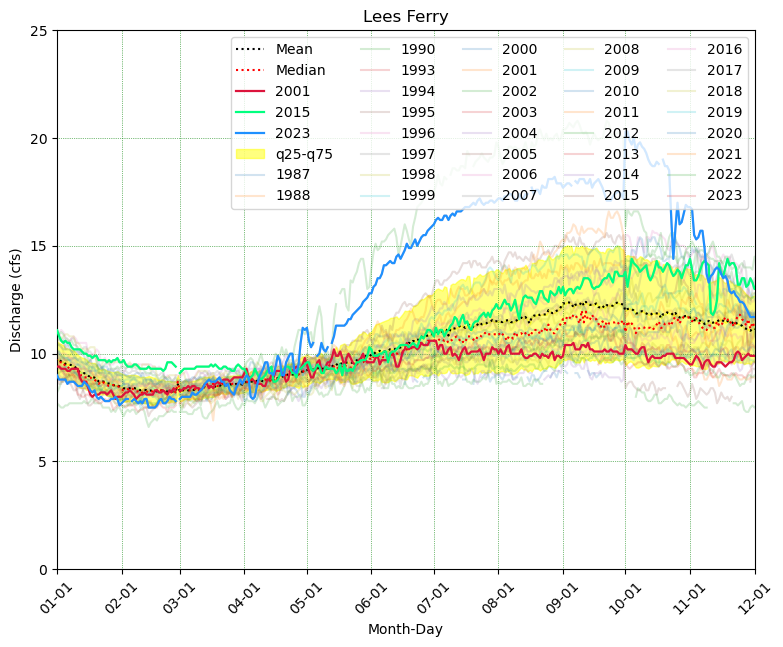

In [3]:
LeesFerry2 = StackedLinePlot(csv_path="leesferry_webservice.csv", name_of_date_column='dateTime', name_of_Q_column='value')
# LeesFerry2 = StackedLinePlot(csv_path=df, name_of_date_column='dateTime', name_of_Q_column='value')
LeesFerry2.calculate_statistics()
LeesFerry2.plotStackedLinePlot(
    # forced_x_positions=[274, 305, 336, 1, 32, 60, 91, 121, 152, 182, 213, 244],  
    # forced_x_labels=['10-01', '11-01', '12-01', '01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01'],  # Added comma here
    title="Lees Ferry",
    highlight_years=[2001, 2015, 2023],
    plot_central_tendency_stats=True,
    quartile_shading=True,
    quartile_shading_alpha=.5,
    quartile_shading_zorder=1,
    series_labels=True,
    series_alpha=.2,
    group_by_decade=False,
    decade_stats_to_plot="All",
    y_lower_lim=0,
    y_upper_lim=25,
    # legend_mode="partial",
    legend_pos='upper right',
    legend_ncol=5,
    input_start_year=1950,
    input_end_year=2023
)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import calendar

class LowHighFlowYear(StackedLinePlot):
    
    def __init__(self, csv_path, name_of_date_column, name_of_Q_column):
        super().__init__(csv_path, name_of_date_column, name_of_Q_column)
        self._yearly_stats_df = None
        self._lowflow_years = None
        self._highflow_years = None
        self._lowflow_stats = None
        self._highflow_stats = None
    
#     def _prepare_data_for_plotting(self, start_year, end_year, **kwargs):
#         water_year = kwargs.get('water_year', True)
#         if water_year:
#             year = 'Water Year'
#         else:
#             year = 'Year'
            
#         self._df = self._df[(self._df[year] >= start_year) & (self._df[year] <= end_year)]
#         self._unique_years = self._df[year].unique()
#         self._start_year, self._end_year = self._unique_years[0], self._unique_years[-1]
#         self._num_of_decades = math.ceil((self._end_year - self._start_year) / 10)
#         self._unique_decades = self._df[year].apply(lambda year: (year // 10) * 10).unique()

#         # Convert years in _pivot_table to water years
#         water_year_col = self._df['Water Year'].unique()
#         self._pivot_table = self._df.copy()
#         self._pivot_table['month-day'] = self._pivot_table['Date'].apply(lambda x: x.strftime('%m-%d'))
#         self._pivot_table = self._pivot_table.pivot(index="month-day", columns=year, values=self._name_of_Q_column)
#         self._pivot_table = self._pivot_table[water_year_col]
#         self._pivot_table_monthly = self._df.pivot(columns='month', values=self._name_of_Q_column)
#         self._pivot_table_yearly_stats = {year: self._pivot_table.iloc[:, i].describe() for i, year in enumerate(self._pivot_table.columns)}

        
#         # self._pivot_table = self._df.pivot(index="month-day", columns=year, values=self._name_of_Q_column)
#         # self._pivot_table = self._pivot_table[water_year_col]
#         # self._pivot_table_monthly = self._df.pivot(columns='month', values=self._name_of_Q_column)
#         # self._pivot_table_yearly_stats = {year: self._pivot_table.iloc[:, i].describe() for i, year in enumerate(self._pivot_table.columns)}

#         self.calculate_statistics()
        
    def calculateLowHighFlowStatistics(self, n_years, **kwargs):
        self._prepare_data_for_plotting(kwargs.get('input_start_year', 2010), kwargs.get('input_end_year', 2020))
        
        yearly_stats = {i: self._pivot_table.loc[:, i].describe() for i in self._pivot_table.columns}
        self._yearly_stats_df = pd.DataFrame([yearly_stats])
        yearly_means = {i: yearly_stats[i].T['mean'] for i in self._pivot_table.columns}
        yearly_means_df = pd.DataFrame([yearly_means]).T.reset_index()
        yearly_means_df.columns = ['Year', 'Mean']
        yearly_means_df = yearly_means_df.sort_values(by=['Mean'], ascending=True).set_index('Year')
        lowflow_years_means_df = yearly_means_df.iloc[:n_years, :]
        highflow_years_means_df = yearly_means_df.iloc[-n_years:, :]
        self._lowflow_years = sorted(list(lowflow_years_means_df.index)[-n_years:])
        self._highflow_years = sorted(list(highflow_years_means_df.index)[:n_years])

        self._lowflow_pivot_table = self._pivot_table.loc[:, self._lowflow_years]
        lowflow_df = self._df[self._df['Year'].isin(self._lowflow_years)]
        self._lowflow_stats = lowflow_df.groupby("month-day")[self._name_of_Q_column].agg(['mean', 'median', 'std', ("q25", lambda x: x.quantile(0.25)), ("q75", lambda y: y.quantile(0.75))])
        self._lowflow_mean = self._lowflow_stats.iloc[:, 0]
        self._lowflow_median = self._lowflow_stats.iloc[:, 1]
        self._lowflow_percentile25 = self._lowflow_stats.iloc[:, 3]
        self._lowflow_percentile75 = self._lowflow_stats.iloc[:, 4]
        self._lowflow_lower_bound_percentile25 = self._lowflow_mean - self._lowflow_percentile25
        self._lowflow_upper_bound_percentile75 = self._lowflow_mean + self._lowflow_percentile75

        self._highflow_pivot_table = self._pivot_table.loc[:, self._highflow_years]
        highflow_df = self._df[self._df['Year'].isin(self._highflow_years)]
        self._highflow_stats = highflow_df.groupby("month-day")[self._name_of_Q_column].agg(['mean', 'median', 'std', ("q25", lambda x: x.quantile(0.25)), ("q75", lambda y: y.quantile(0.75))])
        self._highflow_mean = self._highflow_stats.iloc[:, 0]
        self._highflow_median = self._highflow_stats.iloc[:, 1]
        self._highflow_percentile25 = self._highflow_stats.iloc[:, 3]
        self._highflow_percentile75 = self._highflow_stats.iloc[:, 4]
        self._highflow_lower_bound_percentile25 = self._highflow_mean - self._highflow_percentile25
        self._highflow_upper_bound_percentile75 = self._highflow_mean + self._highflow_percentile75

    
    
    def plotLowHighStackedLinePlot(self,
                                    forced_x_positions=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 336],
                                    forced_x_labels=['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01'],
                                    title=None,
                                    quartile_shading=True,
                                    quartile_shading_alpha=0.4,
                                    y_upper_lim=25, #"Auto",
                                    legend='upper right',
                                    legend_ncol=1):
        self._forced_x_positions = forced_x_positions
        self._forced_x_labels = forced_x_labels

        fig, ax = plt.subplots(figsize=(9, 7))
        self._lowflow_mean.plot(ax=ax, label="Mean", linestyle='--', color='black', linewidth=2.0, zorder=3)
        self._lowflow_median.plot(ax=ax, label="Median", linestyle='--', color='red', linewidth=2.0, zorder=3)

        valid_years = [year for year in self._lowflow_pivot_table.columns if self._lowflow_pivot_table[year].count() > 300]
        filtered_lowflow_pivot_table = self._lowflow_pivot_table.loc[:, valid_years]
        filtered_lowflow_pivot_table.plot(ax=ax, alpha=1, zorder=2, linewidth=1.0, color=self._colors)

        if self._forced_x_positions is not None and self._forced_x_labels is not None:
            ax.set_xticks(self._forced_x_positions)
            xlim_min = self._forced_x_positions[0]
            xlim_max = self._forced_x_positions[-1]
            ax.set_xticklabels(self._forced_x_labels, rotation=45)
            ax.set_xlim([xlim_min, xlim_max])
            ax.set_ylim([0, y_upper_lim])

            plt.grid(color='green', linestyle=":", linewidth=0.5)
            plt.xlabel('Month-Day')
            plt.ylabel('Q (cfs)')
            plt.title("{} - low water years".format(title))
            plt.legend(loc=legend, ncol=legend_ncol)
            plt.show()

        fig, ax = plt.subplots(figsize=(9, 7))
        self._highflow_mean.plot(ax=ax, label="Mean", linestyle='--', color='black', linewidth=2.0, zorder=3)
        self._highflow_median.plot(ax=ax, label="Median", linestyle='--', color='red', linewidth=2.0, zorder=3)

        valid_years = [year for year in self._highflow_pivot_table.columns if self._highflow_pivot_table[year].count() > 300]
        filtered_highflow_pivot_table = self._highflow_pivot_table.loc[:, valid_years]
        filtered_highflow_pivot_table.plot(ax=ax, alpha=1, zorder=2, linewidth=1.0)

#         if self._forced_x_positions is not None and self._forced_x
        if self._forced_x_positions is not None and self._forced_x_labels is not None:
            ax.set_xticks(self._forced_x_positions)
            xlim_min = self._forced_x_positions[0]
            xlim_max = self._forced_x_positions[-1]
            ax.set_xticklabels(self._forced_x_labels, rotation=45)
            ax.set_xlim([xlim_min, xlim_max])
            ax.set_ylim([0, y_upper_lim])

            plt.grid(color='green', linestyle=":", linewidth=0.5)
            plt.xlabel('Month-Day')
            plt.ylabel('Q (cfs)')
            plt.title("{} - high water years".format(title))
            plt.legend(loc=legend, ncol=legend_ncol)
            plt.show()

Importing CSV with the file path: leesferry_webservice.csv
[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 336]
['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01']


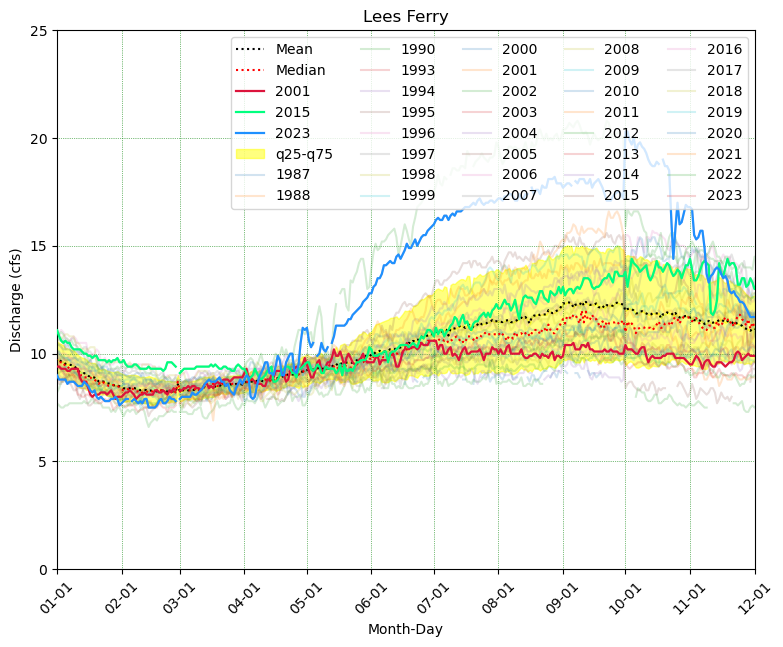

In [14]:
LeesFerry2 = LowHighFlowYear(csv_path="leesferry_webservice.csv", name_of_date_column='dateTime', name_of_Q_column='value')
# LeesFerry2 = StackedLinePlot(csv_path=df, name_of_date_column='dateTime', name_of_Q_column='value')
LeesFerry2.calculate_statistics()
LeesFerry2.plotStackedLinePlot(
    # forced_x_positions=[274, 305, 336, 1, 32, 60, 91, 121, 152, 182, 213, 244],  
    # forced_x_labels=['10-01', '11-01', '12-01', '01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01'],  # Added comma here
    title="Lees Ferry",
    highlight_years=[2001, 2015, 2023],
    plot_central_tendency_stats=True,
    quartile_shading=True,
    quartile_shading_alpha=.5,
    quartile_shading_zorder=1,
    series_labels=True,
    series_alpha=.2,
    group_by_decade=False,
    decade_stats_to_plot="All",
    y_lower_lim=0,
    y_upper_lim=25,
    # legend_mode="partial",
    legend_pos='upper right',
    legend_ncol=5,
    input_start_year=1950,
    input_end_year=2023
)

Importing CSV with the file path: leesferry_webservice.csv


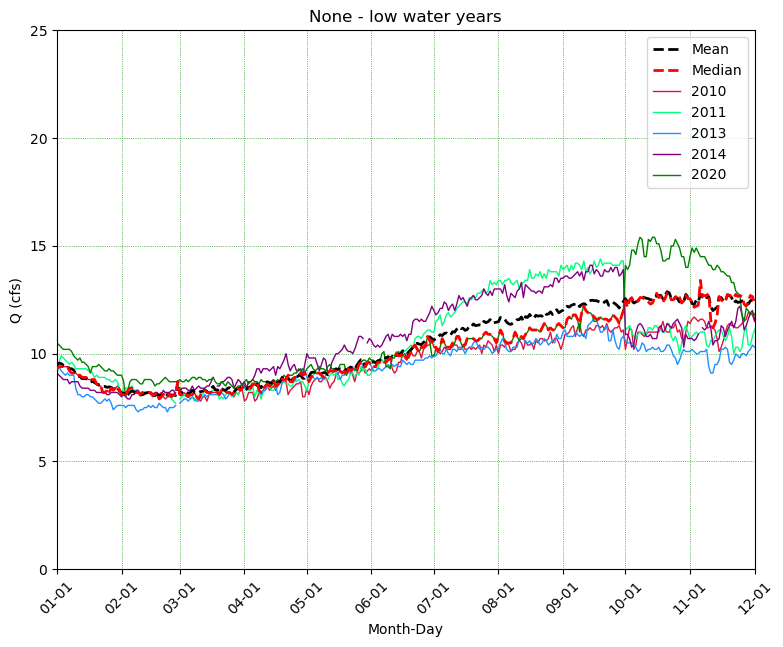

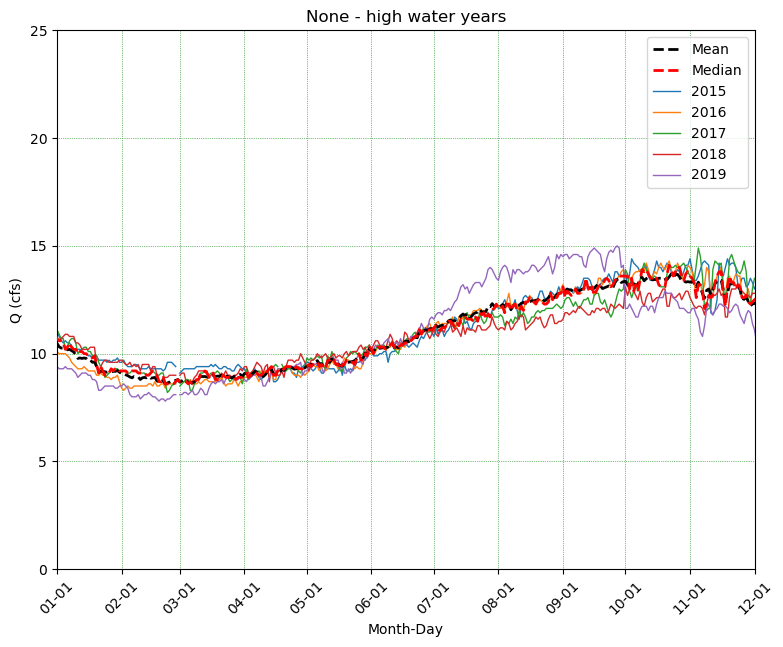

In [26]:
LeesFerry2 = LowHighFlowYear(csv_path="leesferry_webservice.csv", name_of_date_column='dateTime', name_of_Q_column='value')
LeesFerry2.calculateLowHighFlowStatistics(n_years=5)
LeesFerry2.plotLowHighStackedLinePlot()